# Part 4 - Applying spatial filters

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-Case" data-toc-modified-id="Use-Case-1">Use Case</a></span></li><li><span><a href="#Import-and-Data-Preparation" data-toc-modified-id="Import-and-Data-Preparation-2">Import and Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Input-Data-(Freeway)" data-toc-modified-id="Input-Data-(Freeway)-2.1">Input Data (Freeway)</a></span></li><li><span><a href="#Input-Data-(Fire)" data-toc-modified-id="Input-Data-(Fire)-2.2">Input Data (Fire)</a></span></li><li><span><a href="#Input-Data-(Wilderness-Preservation-Area)" data-toc-modified-id="Input-Data-(Wilderness-Preservation-Area)-2.3">Input Data (Wilderness Preservation Area)</a></span></li><li><span><a href="#State-and-County-Boundaries-from-Geoenrichment" data-toc-modified-id="State-and-County-Boundaries-from-Geoenrichment-2.4">State and County Boundaries from Geoenrichment</a></span></li></ul></li><li><span><a href="#arcgis.geometry.filters-module" data-toc-modified-id="arcgis.geometry.filters-module-3"><code>arcgis.geometry.filters</code> module</a></span><ul class="toc-item"><li><span><a href="#intersects" data-toc-modified-id="intersects-3.1"><code>intersects</code></a></span></li></ul></li><li><span><a href="#contains-V.S.-within" data-toc-modified-id="contains-V.S.-within-4"><code>contains</code> V.S. <code>within</code></a></span><ul class="toc-item"><li><span><a href="#crosses-V.S.-overlaps" data-toc-modified-id="crosses-V.S.-overlaps-4.1"><code>crosses</code> V.S. <code>overlaps</code></a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-filtered-results" data-toc-modified-id="Visualizing-the-filtered-results-4.1.1">Visualizing the filtered results</a></span></li><li><span><a href="#Consider-the-impacted-roads" data-toc-modified-id="Consider-the-impacted-roads-4.1.2">Consider the impacted roads</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li></ul></div>

Previously, [Part 3](../part3-spatial-operations-on-geometries) of this guide series to `arcgis.geometry` module, you have been introduced to two ways of conducting spatial operations such as `union` and `intersection`, with `ArcGIS API for Python` - the OOP style vs calling tools off `arcgis.geometry.functions`. Now in Part 4 let us continue to explore how the spatial filtering can be applied within the `arcgis.geometry.filters` sub-module. This module includes functions to filter query results using a spatial relationship with another geometry. It is used when querying feature layers and imagery layers. The spatial filtering is even more powerful, when integrated with `geoenrichment`.

## Use Case

For example, Jim is a Highway Engineer working for the Department of Transportation, and he is performing some fact checking with interstate highways in California. Let's see how he takes advantage of the `arcgis.geometry.filters` in answering these questions:
  - Among all Interstate Highways in the United States, which ones go through San Bernadino County of California, and which ones go through the Los Angeles County.
  - Are there any highways that are wholly contained inside San Bernadino County? Are there any ones that only run inside the LA County?
  - Check if any of the Interstate Highways are too close to the wilderness protected areas in San Bernadino County.
  - In case of wildfires, are the wilderness protected areas in a safe distance from the incidents? and which Interstate Highways are too close to the areas impacted by wildfires?
  
  
## Import and Data Preparation

First of all, let us import the necessary libraries, and then create a GIS connection object to the ArcGIS online organization.

In [ ]:
from arcgis.gis import GIS
from arcgis.geometry import Geometry, Polyline, Point, union
from arcgis.geometry.filters import intersects, contains, overlaps, crosses, touches, within
from arcgis.geometry.filters import envelope_intersects, index_intersects
from arcgis.geoenrichment import Country
from arcgis.features import FeatureLayer

In [2]:
gis = GIS('home')

### Input Data (Freeway)

<Item title:"USA Freeway System" type:Feature Layer Collection owner:esri_dm>
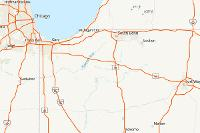

In [3]:
freeway_item = gis.content.search("USA Freeway System AND type:Feature Layer", outside_org=True)[0]
freeway_item

In [4]:
freeway_lyr = freeway_item.layers[0]
freeway_lyr

<FeatureLayer url:"https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Freeway_System/FeatureServer/1">

### Input Data (Fire)

<Item title:"USA Current Wildfires" type:Feature Layer Collection owner:esri_livefeeds2>
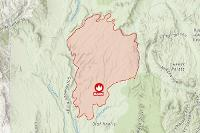

In [5]:
wildfire_item = gis.content.search("USA Current Wildfires AND type:Feature Layer", outside_org=True)[0]
wildfire_item

In [6]:
wildfire_lyr = wildfire_item.layers[0]
wildfire_lyr

<FeatureLayer url:"https://services9.arcgis.com/RHVPKKiFTONKtxq3/arcgis/rest/services/USA_Wildfires_v1/FeatureServer/0">

### Input Data (Wilderness Preservation Area)

<Item title:"Wilderness Areas in the United States" type:Feature Layer Collection owner:wildernesswebmaster99>
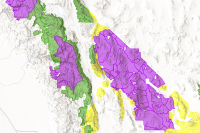

In [7]:
# "Wilderness Areas in the United States"
wild_areas_item = gis.content.search("Wilderness Areas in the United States AND owner:wildernesswebmaster99",
                                     item_type="Feature Layer",
                                     outside_org=True)[0]
wild_areas_item

In [8]:
wild_areas_lyr = wild_areas_item.layers[1]
wild_areas_lyr

<FeatureLayer url:"https://services1.arcgis.com/ERdCHt0sNM6dENSD/arcgis/rest/services/Wilderness_Areas_in_the_United_States/FeatureServer/0">

### State and County Boundaries from Geoenrichment

[`GeoEnrichment`](https://developers.arcgis.com/python/guide/performing-geoenrichment/) provides the ability to get facts about a location or area. Using GeoEnrichment, you can get information about the people, places, and businesses in a specific area or within a certain distance or drive time from a location. It enables you to query and use information from a large collection of data sets including population, income, housing, consumer behavior, and the natural environment.

Next, `arcgis.geoenrichment.Country` is used to derive the geometries of the San Bernadino County, the LA County, and the Riverside County.

In [9]:
usa = Country.get('US')
type(usa)

arcgis.geoenrichment.enrichment.Country

To learn more about GeoEnrichment, refer to the guide on this module [here](../part1-introduction-to-geoenrichment/).

<NamedArea name:"United States" area_id="06071", level="US.Counties", country="United States">

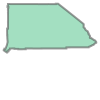

In [10]:
named_area_sb_county = usa.subgeographies.states['California'].counties['San_Bernardino_County']
display(named_area_sb_county)
named_area_sb_county.geometry.as_shapely

In [11]:
sr_sb_county = named_area_sb_county.geometry["spatialReference"]
sr_sb_county

{'wkid': 4326, 'latestWkid': 4326}

<NamedArea name:"United States" area_id="06037", level="US.Counties", country="United States">

Geometry failed validation: Hole lies outside shell[-118.595126083686 33.0359593618555]. Repairing with `buffer(0)`.


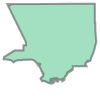

In [12]:
named_area_la_county = usa.search(query='Los Angeles', layers=['US.Counties'])
display(named_area_la_county[0])
named_area_la_county[0].geometry.as_shapely

<NamedArea name:"United States" area_id="06065", level="US.Counties", country="United States">

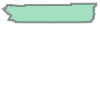

In [13]:
named_area_riverside_county = usa.search(query='Riverside', layers=['US.Counties'])
display(named_area_riverside_county[0])
named_area_riverside_county[0].geometry.as_shapely

## `arcgis.geometry.filters` module

Now all input data are ready, you are all set up to start creating spatial filters! The `arcgis.geometry.filters` module contains functions to filter query results of a feature or imagery layer by a spatial relationship with another geometry. You are going to see how `intersects()`, `contains`, etc. are being used to answer Jim's questions in the following sections. Before we get started, let us visualize how these layers and counties overlay spatially with a help of a map.


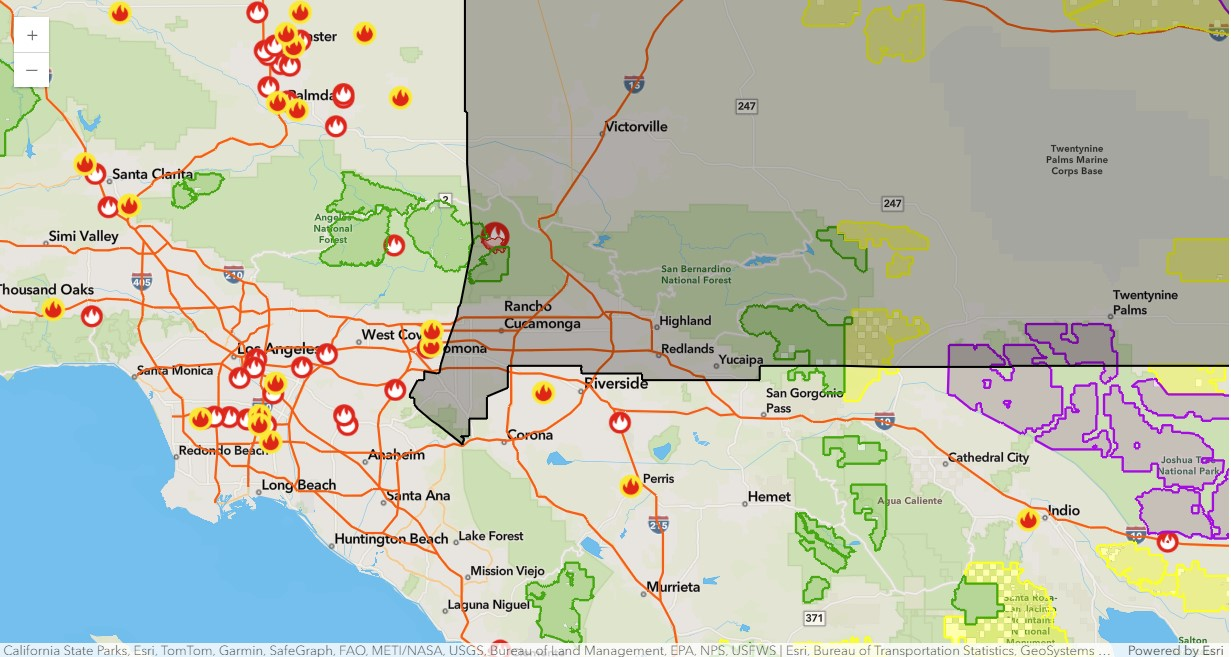

In [53]:
map1 = gis.map('San Bernardino, California')
map1

In [17]:
map1.zoom = 8

In [16]:
# map1.content.add(freeway_item) # red lines
map1.content.add(wildfire_item) # dots
map1.content.add(wild_areas_item) # polygons

# draw the counties
map1.content.draw(named_area_sb_county.geometry) # large gray polygon

### `intersects`

To find which parts of interstate highways layer intersect with the county of San Bernardino (or county of Los Angeles for instance), we will use `arcgis.geometry.filters.intersects(geometry, sr=None)` to create a geometry filter object that filters results whose geometry intersects with the specified geometry.

In [18]:
# construct a geometry filter using the filter geometry
sb_county_filter = intersects(named_area_sb_county.geometry, 
                              sr=sr_sb_county)
type(sb_county_filter)

dict

In [19]:
sb_county_filter.keys()

dict_keys(['geometry', 'geometryType', 'spatialRel', 'inSR'])

In [20]:
sb_county_filter['spatialRel']

'esriSpatialRelIntersects'

In [21]:
# query a feature layer for features that meet filter criteria
df_sb_county_Interstate = freeway_lyr.query(geometry_filter=sb_county_filter, 
                                            as_df=True)
df_sb_county_Interstate[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]]

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM
0,639,I40,2388.99433,3844.72138
1,672,I15,1410.53954,2270.04788
2,48,S60,66.98541,107.80279
3,139,I10,2367.17447,3809.60565
4,42,S66,14.10566,22.70091
5,4,I215,93.43523,150.36972
6,47,S58,119.34584,192.0689
7,690,S210,40.46925,65.12908


In [22]:
df_sb_county_Interstate["ROUTE_NUM"].tolist()

['I40', 'I15', 'S60', 'I10', 'S66', 'I215', 'S58', 'S210']

The results above of an `intersects` filter on the query show 8 Interstate highways go through (or should we say... intersect) San Bernardino County, namely highways `I215, S66, S58, S60, I10, I40, I15, and S210`. If you are interested in finding out more information about any of the resulting highways, such as the specific geometry/shape, you can run the subsequent two cells to create composite filtering criteria (with `where=` and `geometry_filter=`) to get a finer query result. After that, parse the properties to get more details.

In [23]:
# query a feature layer for features that meet filter criteria
sb_county_I15 = freeway_lyr.query(where="ROUTE_NUM = 'I15'",
                                  geometry_filter=sb_county_filter)
sb_county_I15

<FeatureSet> 1 features

In [24]:
for feature in sb_county_I15.features:
    print(feature.attributes)   
    geom_dict = feature.geometry
    geom_dict["spatialReference"] = sr_sb_county
    freeway_obj = Polyline(geom_dict)
    display(freeway_obj.as_arcpy)

{'OBJECTID': 672, 'ROUTE_NUM': 'I15', 'CLASS': 'I', 'NUMBER': '15', 'SUFFIX': ' ', 'DIST_MILES': 1410.53954, 'DIST_KM': 2270.04788}


None

Similar to querying for highways intersecting the SB County, you can also query highways that intersect Los Angeles county.

In [25]:
# construct a geometry filter using the filter geometry
la_county_filter = intersects(named_area_la_county[0].geometry, 
                              sr=sr_sb_county)

In [26]:
# query a feature layer for features that meet filter criteria
df_la_county_Interstate = freeway_lyr.query(geometry_filter=la_county_filter, 
                                            as_df=True)
display(df_la_county_Interstate.shape)
df_la_county_Interstate[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]].head()

(24, 8)

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM
0,29,S134,12.30291,19.79965
1,673,I405,103.87974,167.17858
2,52,S71,4.57118,7.35661
3,35,S2,7.95003,12.79435
4,690,S210,40.46925,65.12908


When the same highways feature layer was queried using the LA County filter, the query result had 24 entries (as seen from the shape of the DataFrame object). This means 24 interstate highways intersect LA County.

If interested in finding out more information about route `U101`, you can run the following two cells to create composite filtering criteria with `where` and `geometry_filter`, get a finer search result, and parse the detailed properties.

In [27]:
# query a feature layer for features that meet filter criteria
la_county_U101 = freeway_lyr.query(where="ROUTE_NUM = 'U101'",
                                   geometry_filter=la_county_filter)
la_county_U101

<FeatureSet> 1 features

In [28]:
for feature in la_county_U101.features:
    print(feature.attributes)   
    geom_dict = feature.geometry
    geom_dict["spatialReference"] = sr_sb_county
    freeway_obj = Polyline(geom_dict)
    display(freeway_obj.as_arcpy)

{'OBJECTID': 675, 'ROUTE_NUM': 'U101', 'CLASS': 'U', 'NUMBER': '101', 'SUFFIX': ' ', 'DIST_MILES': 722.19665, 'DIST_KM': 1162.26517}


None

## `contains` V.S. `within`

In the previous section, we have sorted out that 8 Interstate Highways, namely `I215, S66, S58, S60, I10, I40, I15, and S210`, intersect with county of San Bernardino, and 24 routes intersect with LA County. Now, let us find out which highways are entirely contained in these counties. You will need to use `arcgis.geometry.filters.contains(geometry, sr=None)` to compose the spatial filter that aims to return a feature if its shape is wholly contained within the search geometry (valid for all shape type combinations).

On a side note, `arcgis.geometry.filters.within(geometry, sr=None)` is the opposite to `contains` in that it returns a feature if its shape wholly contains the search geometry (valid for all shape type combinations).

In [29]:
# construct a geometry filter using the filter geometry
sb_county_filter2 = contains(named_area_sb_county.geometry, 
                             sr=sr_sb_county)

In [30]:
# query a feature layer for features that meet filter criteria
df_sb_county_Interstate2 = freeway_lyr.query(geometry_filter=sb_county_filter2, 
                                           as_df=True)
display(df_sb_county_Interstate2.shape)
df_sb_county_Interstate2[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]].head()

(0, 8)

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM


From the cell output above, none of Interstate Highways is contained within the county boundaries of SB County. What about the county of Los Angeles?

In [31]:
# construct a geometry filter using the filter geometry
la_county_filter2 = contains(named_area_la_county[0].geometry, 
                             sr=sr_sb_county)

In [32]:
# query a feature layer for features that meet filter criteria
df_la_county_Interstate2 = freeway_lyr.query(geometry_filter=la_county_filter2, 
                                             as_df=True)
display(df_la_county_Interstate2.shape)
df_la_county_Interstate2[["OBJECTID","ROUTE_NUM","DIST_MILES","DIST_KM"]].head()

(9, 8)

,OBJECTID,ROUTE_NUM,DIST_MILES,DIST_KM
0,29,S134,12.30291,19.79965
1,52,S71,4.57118,7.35661
2,35,S2,7.95003,12.79435
3,24,S110,9.08802,14.62578
4,22,S10,0.63953,1.02922



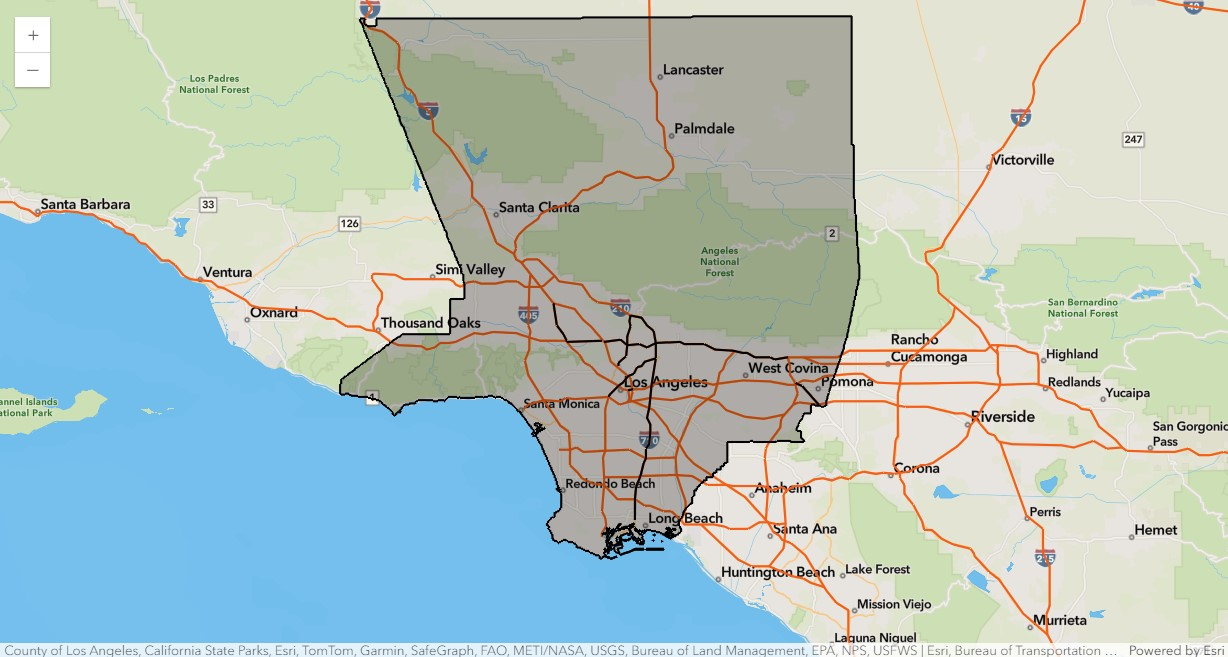

In [54]:
map2 = gis.map('Los Angeles County, California')
map2

In [34]:
map2.content.add(freeway_item)
map2.content.draw(named_area_la_county[0].geometry)
df_la_county_Interstate2.spatial.plot(map2)

True

The map above displays the boundary of LA county and the highways (black) that are fully contained within it. The cells below assert this claim by comparing the names of higways that intersect vs is contained withint the county boundaries.

In [35]:
num_contained = 0
for route_num in df_la_county_Interstate2["ROUTE_NUM"]:
    if route_num not in df_la_county_Interstate["ROUTE_NUM"]:
        num_contained+=1
print(num_contained, "out of 9 are contained in LA County, and not intersecting with County Boundaries")

9 out of 9 are contained in LA County, and not intersecting with County Boundaries


In [36]:
num_intersecting = 0
for route_num in df_la_county_Interstate["ROUTE_NUM"]:
    if route_num not in df_la_county_Interstate2["ROUTE_NUM"]:
        num_intersecting+=1
print(num_intersecting, "out of 24 are intersecting with County Boundaries, but not contained in LA County")

24 out of 24 are intersecting with County Boundaries, but not contained in LA County


### `crosses` V.S. `overlaps`

Filters `crosses` and `overlaps` share some common aspects in their definitions:
  - `arcgis.geometry.filters.crosses(geometry, sr=None)` returns a feature if the intersection of the interiors of the two shapes is not empty and has a lower dimension than the maximum dimension of the two shapes. Two lines that share an endpoint in common do not cross. Valid for Line/Line, Line/Area, Multi-point/Area, and Multi-point/Line shape type combinations.
  - `arcgis.geometry.filters.overlaps(geometry, sr=None)` returns a feature if the intersection of the two shapes results in an object of the same dimension, but different from both of the shapes. Applies to Area/Area, Line/Line, and Multi-point/Multi-point shape type combinations.

The major difference is that `overlaps` requires two shapes with the same dimension (e.g. Area/Area, Line/Line, and Multi-point/Multi-point shape type combinations), while `crosses` can operate on two shapes whose intersection has a lower dimension than the maximum dimension of the two.

In [37]:
# query a feature layer for features that meet filter criteria
df_la_county_wildfire = wildfire_lyr.query(geometry_filter=la_county_filter)
df_la_county_wildfire

<FeatureSet> 50 features

The query above returns wildfire incidents inside SB County. Next, we can now loop through each fire incident (point feature), create a buffer around them and apply `overlaps` spatial filter to identify which wilderness preservation areas overlap with the fire buffer.

<div class="alert alert-info">
    <b>Note:</b> The <code>wild_areas_lyr</code> layer pulls live wildfire information. Hence, when you run this notebook, you might see different set of results for the cells below.
</div>

In [38]:
fire_buffer_list = []
wild_areas_list = []

# loop through all point features - wildfire incidents
for feature in df_la_county_wildfire.features:
    dict_geom = feature.geometry
    dict_geom["spatialReference"] = sr_sb_county
    
    # create buffered area around the wildfire centers
    f_buffer = Point(dict_geom).buffer(0.05).generalize(0.01)
    fire_buffer_list.append([feature.get_value("IncidentName"), f_buffer])
    
    # creates a spatial filter
    f_buffer_filter = overlaps(f_buffer, sr=sr_sb_county)
    
    # query a feature layer for features that meet filter criteria;
    # result == wilderness prevention areas that overlap with the wildfire buffered zones
    f_buffer_wild_areas = wild_areas_lyr.query(geometry_filter=f_buffer_filter)
    df_f_buffer_wild_areas = f_buffer_wild_areas.sdf
    
    # print results and save
    if df_f_buffer_wild_areas.shape[0] > 0:
        display(df_f_buffer_wild_areas[["NAME","Agency"]])
        wild_areas_list.append(f_buffer_wild_areas)

,NAME,Agency
0,San Gabriel Wilderness,FS
1,Sheep Mountain Wilderness,FS


#### Visualizing the filtered results

Next, let us visualize the **wildfires**, the **buffered zone impacted by wildfires**, and the impacted **wilderness preservation areas** on a single MapView.


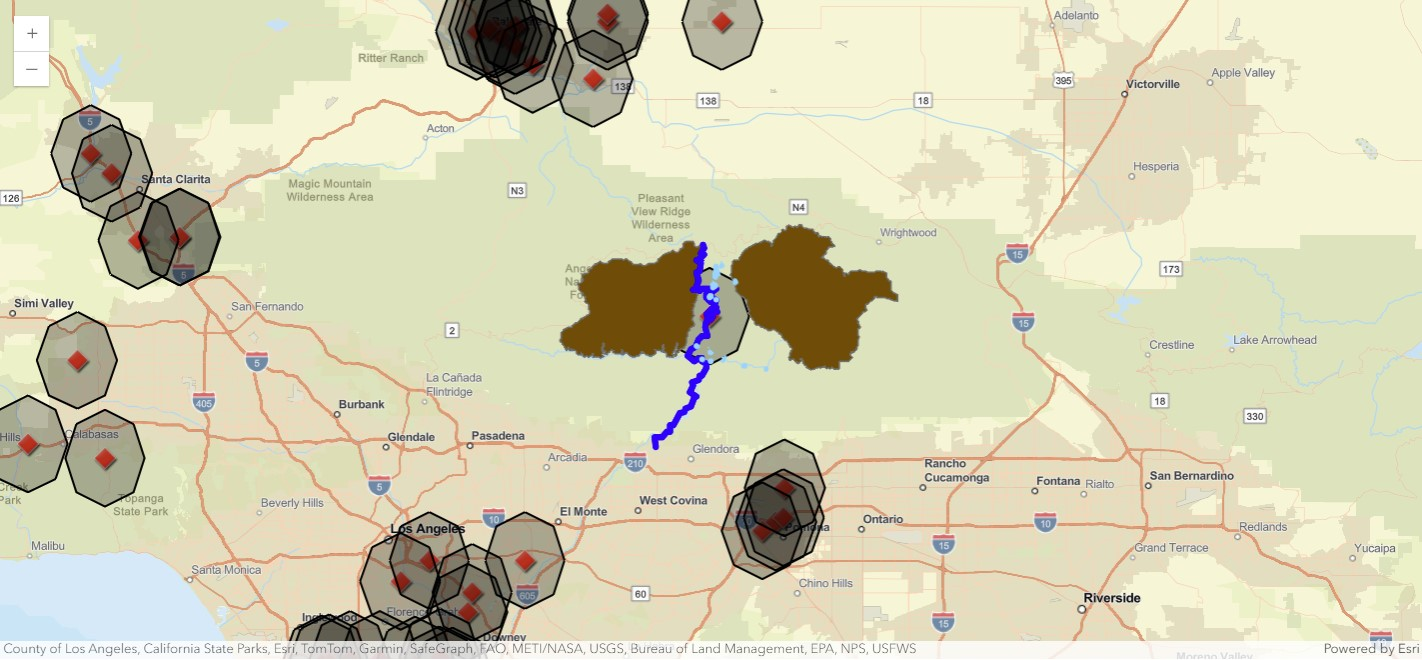

In [55]:
map3 = gis.map('Redlands, CA')
map3.basemap.basemap = 'arcgis-streets'
map3

In [52]:
map3.center = [34.270181708311824, -117.83974640027999]
map3.zoom = 9

In [42]:
from arcgis.map.symbols import PictureMarkerSymbolEsriPMS, SimpleFillSymbolEsriSFS, SimpleLineSymbolEsriSLS, SimpleLineSymbolStyle
# draw the fires as diamonds
map3.content.draw(df_la_county_wildfire,
          symbol = PictureMarkerSymbolEsriPMS(**{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS",
                    "url":"http://static.arcgis.com/images/Symbols/Shapes/RedDiamondLargeB.png",
                    "contentType":"image/png","width":24,"height":24}))

# draw buffers around fires
for f_b in fire_buffer_list:
    map3.content.draw(f_b[1])

# draw the wild areas affeted
for w_a in wild_areas_list:
    map3.content.draw(w_a,
              symbol = SimpleFillSymbolEsriSFS(**{"type" : "esriSFS","style": "esriSFSSolid",
                        "color": [115,76,0,255],
                          "outline": {"type": "esriSLS","style": "esriSLSSolid",
                              "color": [110,110,110,255],"width": 1
                          }
                      }))

#### Consider the impacted roads

In order to decide what secondary roads and local roads might get affected by the wildfire in SB County, we need to first create a FeatureLayer object from the transportation <a href="https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer">resources</a> provided by census bureau.

In [43]:
fl_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer"
secondary_roads_layer = FeatureLayer(fl_url+"/1")
local_roads_layer = FeatureLayer(fl_url+"/2")

We can use the class `PythonSwitch` defined below to explore all possible spatial relations within `arcgis.geometry.filters`, and discover the differences of each spatial filter:

In [44]:
# Implement Python Switch Case Statement using Class
class PythonSwitch:
    def switch(self, op):
        default = "Unsupported Operation"
        return getattr(self, 'case_' + str(op), lambda: default)()

    def case_1(self):
        return crosses(f_buffer[1], sr=sr_sb_county)
 
    def case_2(self):
        return contains(f_buffer[1], sr=sr_sb_county)
 
    def case_3(self):
        return intersects(f_buffer[1], sr=sr_sb_county)

    def case_4(self):
        return touches(f_buffer[1], sr=sr_sb_county)
 
    def case_5(self):
        return within(f_buffer[1], sr=sr_sb_county)
    
    def case_6(self):
        return envelope_intersects(f_buffer[1], sr=sr_sb_county)
 
    def case_7(self):
        return index_intersects(f_buffer[1], sr=sr_sb_county)

In [45]:
# For experimental purposes, just target at one of the fire buffered areas
op_list = ['crosses','contains','intersects','touches','within','envelope_intersects','index_intersects']
for f_buffer in fire_buffer_list:
    if f_buffer[0] == "MOON":
        # switch case to loop thru all spatial relations
        for i in range(1,8):
            # creates a spatial filter
            s = PythonSwitch()
            f_buffer_filter = s.switch(i)
        
            # query a feature layer for features that meet filter criteria
            f_buffer_sec_roads = secondary_roads_layer.query(geometry_filter=f_buffer_filter)
            df_f_buffer_sec_roads = f_buffer_sec_roads.sdf
    
            # print results and save
            if df_f_buffer_sec_roads.shape[0] > 0:
                print(f"Op {i} {op_list[i-1]}: {df_f_buffer_sec_roads.shape[0]}")
                display(df_f_buffer_sec_roads[["BASENAME","MTFCC","NAME","OBJECTID"]])
            else:
                print(f"Op {i} {op_list[i-1]}: 0")

Op 1 crosses: 3


,BASENAME,MTFCC,NAME,OBJECTID
0,39,S1200,State Rte 39,102930
1,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,219663
2,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,103239


Op 2 contains: 2


,BASENAME,MTFCC,NAME,OBJECTID
0,Fork San Gabriel,S1200,N Fork San Gabriel Rd,103235
1,Crystal Lake,S1200,Crystal Lake Rd,103202


Op 3 intersects: 5


,BASENAME,MTFCC,NAME,OBJECTID
0,39,S1200,State Rte 39,102930
1,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,219663
2,Fork San Gabriel,S1200,N Fork San Gabriel Rd,103235
3,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,103239
4,Crystal Lake,S1200,Crystal Lake Rd,103202


Op 4 touches: 0
Op 5 within: 0
Op 6 envelope_intersects: 7


,BASENAME,MTFCC,NAME,OBJECTID
0,39,S1200,State Rte 39,102930
1,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,219663
2,2,S1200,State Rte 2,122756
3,Fork San Gabriel,S1200,N Fork San Gabriel Rd,103235
4,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,103239
5,Crystal Lake,S1200,Crystal Lake Rd,103202
6,Angeles Crest,S1200,Angeles Crest Hwy,212231


Op 7 index_intersects: 7


,BASENAME,MTFCC,NAME,OBJECTID
0,39,S1200,State Rte 39,102930
1,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,219663
2,2,S1200,State Rte 2,122756
3,Fork San Gabriel,S1200,N Fork San Gabriel Rd,103235
4,San Gabriel Canyon,S1200,San Gabriel Canyon Rd,103239
5,Crystal Lake,S1200,Crystal Lake Rd,103202
6,Angeles Crest,S1200,Angeles Crest Hwy,212231


After carefully observing the results, we can tell in this example, `index_intersects` works the same way as `envelope_intersects`, and `crosses` & `contains` each represent a mutually exclusive subset of what's derived from `intersects`.

In [47]:
impacted_sec_roads_list = []
impacted_loc_roads_list = []

for f_buffer in fire_buffer_list:
    if f_buffer[0] == "MOON":
        # creates a spatial filter
        s = PythonSwitch()
        f_buffer_filter = s.switch(3)
        ##f_buffer_filter = intersects(f_buffer, sr=sr_sb_county)
        
        # query a feature layer for features that meet filter criteria
        f_buffer_sec_roads = secondary_roads_layer.query(geometry_filter=f_buffer_filter)
        df_f_buffer_sec_roads = f_buffer_sec_roads.sdf
        
        # print results and save
        if df_f_buffer_sec_roads.shape[0] > 0:
            # display(df_f_buffer_sec_roads.shape[0])
            # display(df_f_buffer_sec_roads[["BASENAME","MTFCC","NAME","OBJECTID"]].head())
            impacted_sec_roads_list.append(f_buffer_sec_roads)
            
        # query a feature layer for features that meet filter criteria
        f_buffer_loc_roads = local_roads_layer.query(geometry_filter=f_buffer_filter)
        df_f_buffer_loc_roads = f_buffer_loc_roads.sdf
        
        # print results and save
        if df_f_buffer_loc_roads.shape[0] > 0:
            # display(df_f_buffer_loc_roads.shape[0])
            # display(df_f_buffer_loc_roads[["BASENAME","MTFCC","NAME","OBJECTID"]].head())
            impacted_loc_roads_list.append(f_buffer_loc_roads)

Now that we have obtained `impacted_sec_roads_list` and `impacted_loc_roads_list` that store the secondary and local roads impacted by the wildfire, it is straight forward to just map them in the Map Widget as well.

In [48]:
symbol_sec = SimpleLineSymbolEsriSLS(style=SimpleLineSymbolStyle.esri_sls_solid, color=[0,0,255], width=4)
for road in impacted_sec_roads_list:
    map3.content.draw(road,
              symbol = symbol_sec)

In [49]:
symbol_loc = SimpleLineSymbolEsriSLS(style=SimpleLineSymbolStyle.esri_sls_dot, color=[144,213,255], width=4)
for road in impacted_loc_roads_list:
    map3.content.draw(road,
              symbol = symbol_loc)

## Conclusion

This part 4 of the geometry module guide demonstrated how to construct spatial filter using `arcgis.goemetry.filters` sub-module. These filters are can be applied when querying feature and imagery layers.

The choice to make between various spatial relations for spatial queries depends on what is known prior to executing the query and the type of results needed. If the goal of the query is to find features that satisfy a spatial relationship with a single geometry (or a collection of geometries), use a spatial filter. 
 
What's not mentioned here but still important for improving efficiencies and precisons of queries, is that users should consider `spatial caching` and `tolerance` when executing spatial queries. If multiple spatial queries are going to be executed within a common extent, the use of spatial caching can significantly increase performance by reducing round trips to the data source. A feature class x,y tolerance can have an effect on the results of a spatial query and should be considered when executing spatial queries, particularly with feature classes that have unusually large x,y tolerances. For more information, please check out [Introduction to geometry analysis](/documentation/spatial-analysis-services/geometry-analysis/introduction/).